In [33]:
import pickle
import gc
import datetime
from math import floor, ceil
from time import perf_counter

import numpy as np  
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns;   sns.set_style("whitegrid")

import importlib
import CVA_Module ; importlib.reload(CVA_Module)

from numba import njit
from tqdm.notebook import trange, tqdm_notebook ; tqdm_notebook.pandas()

In [34]:
tickers = ['JPM', 'AFG'] #['ACAFP-CIB', 'UBSGRO', 'EVRGSA', 'ADIG']
T=10

In [35]:
# September 9, 2021
spreads = pd.read_excel('data/pd/cds_spreads.xlsx', index_col=0)

In [36]:
spreads = spreads / 10000

In [37]:
def __get_interpolated_cds_values(df_in : pd.DataFrame , 
                                  frequency : float = 1/52,
                                  method='from_derivatives'):
    _ending_tenor = df_in.index.sort_values()[-1]

    temp_df = df_in.copy(deep=True)
    old_index   = list(temp_df.index)
    new_index   = list(np.arange(0, _ending_tenor+frequency, frequency))
    temp_index  = pd.Index(new_index + old_index).sort_values().drop_duplicates()
    
    temp_df = temp_df.reindex(temp_index)
    
    temp_df = temp_df.astype(float)
    temp_df.sort_index(inplace=True)
    
    temp_df.interpolate(method=method, inplace=True)
    temp_df = temp_df.loc[new_index]
    
    return temp_df

In [38]:
interpolated_cds = {}
for ticker in tickers:
    interpolated = __get_interpolated_cds_values(spreads[ticker])
    interpolated_cds[ticker] = interpolated.loc[interpolated.index <= T]

In [39]:
interpolated_cds = pd.DataFrame(interpolated_cds)
interpolated_cds.index.names = ['t']

## Calculate P(Survival)

In [40]:
interpolated_cds.columns = ['AA_B', 'BBB_C']
recoveries = {'AA_B': 0.4,
           'BBB_C': 0.4}

In [41]:
interpolated_cds = interpolated_cds.reset_index()

In [42]:
# Survival Probabilities
interpolated_cds['Survival_AA_B'] = np.exp(-interpolated_cds['AA_B'] * interpolated_cds['t'] / (1 - recoveries['AA_B']))
interpolated_cds['Survival_BBB_C'] = np.exp(-interpolated_cds['BBB_C'] * interpolated_cds['t'] / (1 - recoveries['BBB_C']))

In [43]:
# AA Bank
interpolated_cds['PD_AA_B'] = (np.exp(-interpolated_cds['AA_B'].shift(1) * interpolated_cds['t'].shift(1) / (1-recoveries['AA_B']))
                          - np.exp(-interpolated_cds['AA_B'] * interpolated_cds['t'] / (1-recoveries['AA_B']))).fillna(0)
# BBB Counterparty
interpolated_cds['PD_BBB_C'] = (np.exp(-interpolated_cds['BBB_C'].shift(1) * interpolated_cds['t'].shift(1) / (1-recoveries['BBB_C']))
                          - np.exp(-interpolated_cds['BBB_C'] * interpolated_cds['t'] / (1-recoveries['BBB_C']))).fillna(0)

In [44]:
interpolated_cds['Rec_AA_B'] = recoveries['AA_B']
interpolated_cds['Rec_BBB_C'] = recoveries['BBB_C']

In [45]:
interpolated_cds.to_excel('data/pd/default_probabilies.xlsx')

''

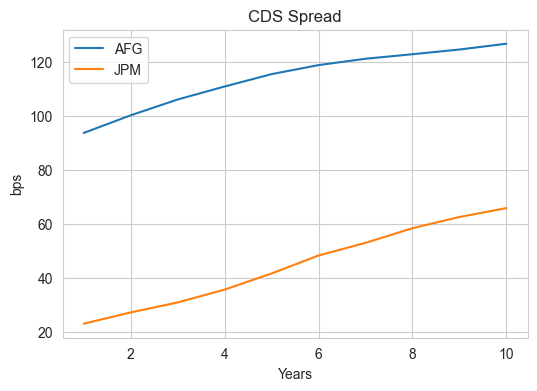

In [46]:
(spreads * 10000).iloc[1:].plot(figsize=(6, 4))
plt.xlabel("Years")
plt.ylabel("bps")
plt.title("CDS Spread")
;

<Axes: >

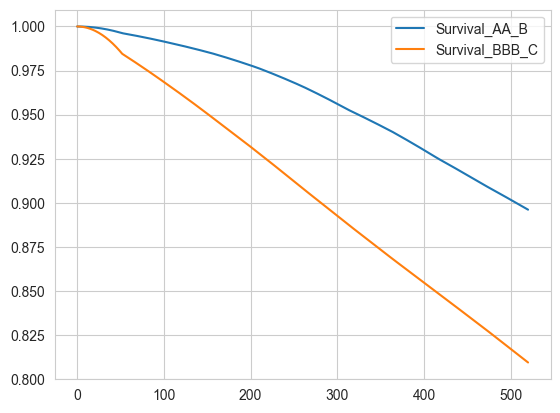

In [47]:
interpolated_cds[['Survival_AA_B', 'Survival_BBB_C']].plot()

''

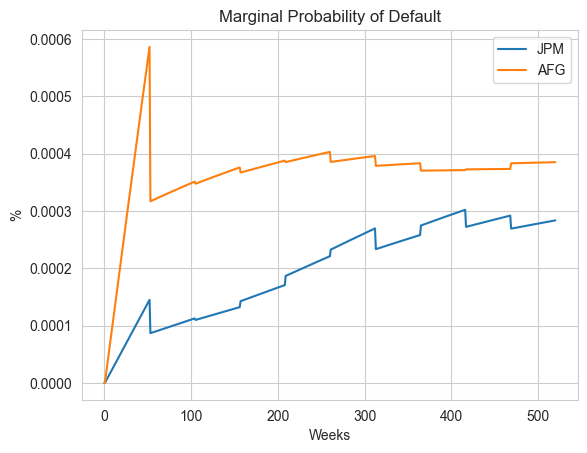

In [48]:
(interpolated_cds[['PD_AA_B', 'PD_BBB_C']]).plot()
plt.xlabel("Weeks")
plt.ylabel("%")
plt.title("Marginal Probability of Default")
plt.legend(['JPM', 'AFG'])
;